In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import igraph as ig
import leidenalg as la

import matplotlib.pyplot as plt

In [2]:
lines = gpd.read_file("../edges_focus.gpkg").rename(columns={'target': 'src',
                                                             'focal': 'trg',
                                                             'weight': 'nij',
                                                             'distance': 'dij'})

In [3]:
lines = lines.to_crs(3857)

In [4]:
G = nx.from_pandas_edgelist(lines, source='src', target='trg', edge_attr=['nij'], create_using=nx.DiGraph)

In [5]:
from cdlib import algorithms
P = algorithms.aslpaw(G)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub', 'wurlitzer', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [6]:
P_long = pd.DataFrame(P.communities).T.melt()
P_long = P_long.dropna()

In [7]:
import cenpy

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census ACS 2018 WMS

In [8]:
metros = pd.read_csv("../data/metrolist_one.csv", nrows=1159, header=None)
metros = metros.set_axis(['metro_fips', 'metro_name', 'county_fips', 'county_name'], axis=1)

bay = metros[(metros.metro_name.str.contains('San Jose')) | (metros.metro_name.str.contains('San Francisco'))]
bay = bay[bay.county_name!="San Benito, CA"]

bay.head()

,metro_fips,metro_name,county_fips,county_name
963,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6001,"Alameda, CA"
964,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6013,"Contra Costa, CA"
965,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6041,"Marin, CA"
966,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6075,"San Francisco, CA"
967,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6081,"San Mateo, CA"


In [9]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'geometry': block_groups.geometry,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

In [10]:
nodes = list()
shape = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    current = get_nodes(fips)
    feature = current.geometry
    
    shape.append(feature)
    nodes.append(current.drop('geometry', axis=1))

nodes = pd.concat(nodes, ignore_index=False)
shape = gpd.GeoDataFrame(pd.concat(shape, ignore_index=False))

In [11]:
water = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    year = 2018
    
    sfips = fips[:2]
    cfips = fips[2:]
    
    url = f"https://www2.census.gov/geo/tiger/TIGER{year}/AREAWATER/tl_{year}_{sfips}{cfips}_areawater.zip"
    
    water.append(gpd.read_file(url))

water = gpd.GeoDataFrame(pd.concat(water, ignore_index=True))

In [12]:
water = water.to_crs(3857)

water_dissolved = water.dissolve()
shape_dissolved = shape.dissolve()
background = shape_dissolved['geometry'].difference(water_dissolved['geometry'])

In [13]:
P_long['crosswalk'] = P_long['value'].astype('uint64')
joined = P_long.merge(shape.reset_index(), left_on='crosswalk', right_on='cbg', how='left')
joined = gpd.GeoDataFrame(joined)

0
1
2
3
4
5
6
7
8
9


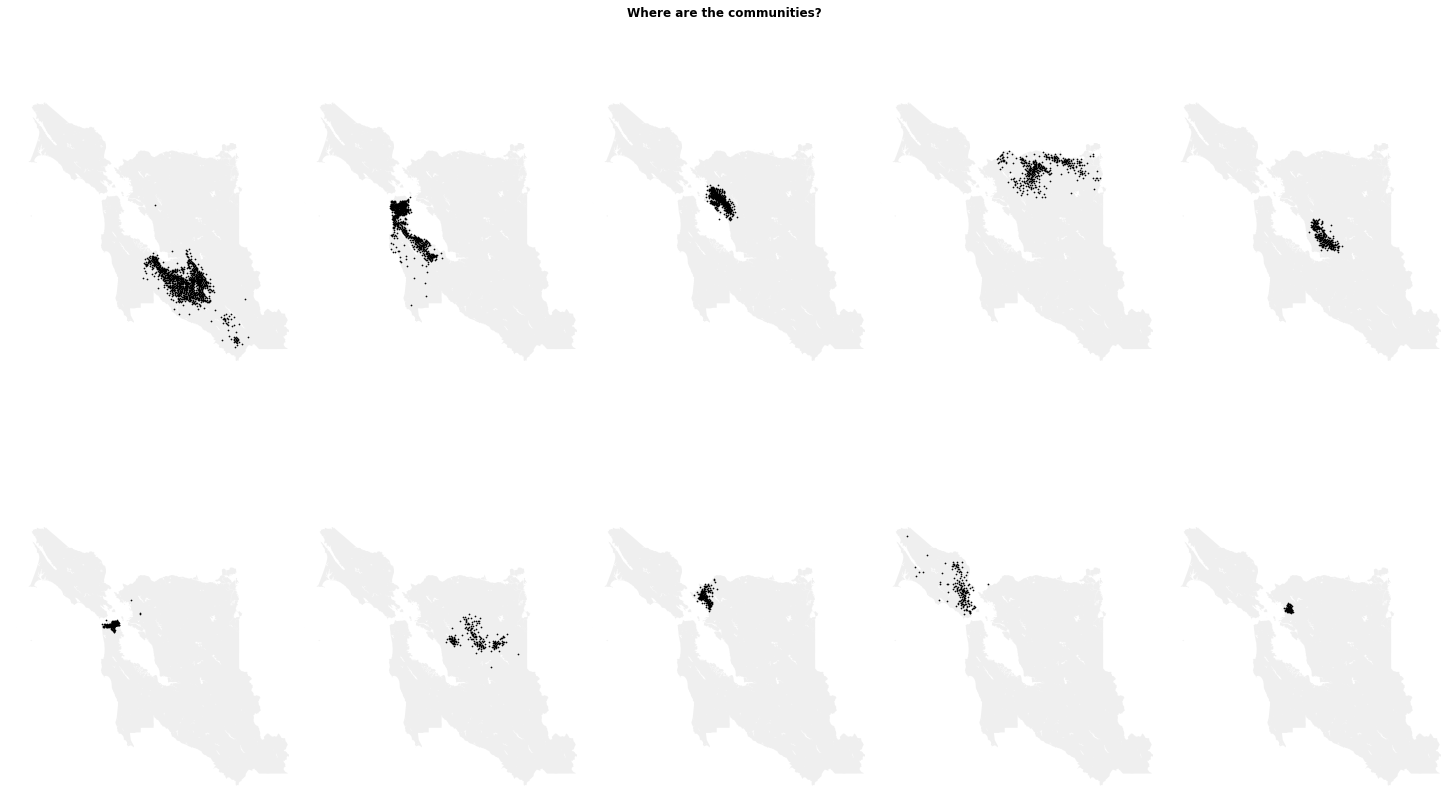

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(20, 12), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 10):
    
    print(i)
    
    temp = joined[joined['variable']==i]
    
    background.plot(color='dimgray', ax=axs[i], alpha=0.1)
    temp.centroid.plot(color='k', markersize=0.5, ax=axs[i])

    axs[i].margins(0)
    axs[i].axis('off')
    
    
fig.suptitle("Where are the communities?", color='k', weight='bold')

fig.savefig('aslpaw_communities.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [15]:
P = algorithms.demon(G, min_com_size=3, epsilon=0.25)

In [17]:
P_long = pd.DataFrame(P.communities).T.melt()
P_long = P_long.dropna()

In [18]:
P_long['crosswalk'] = P_long['value'].astype('uint64')
joined = P_long.merge(shape.reset_index(), left_on='crosswalk', right_on='cbg', how='left')
joined = gpd.GeoDataFrame(joined)

0
1
2
3
4
5
6
7


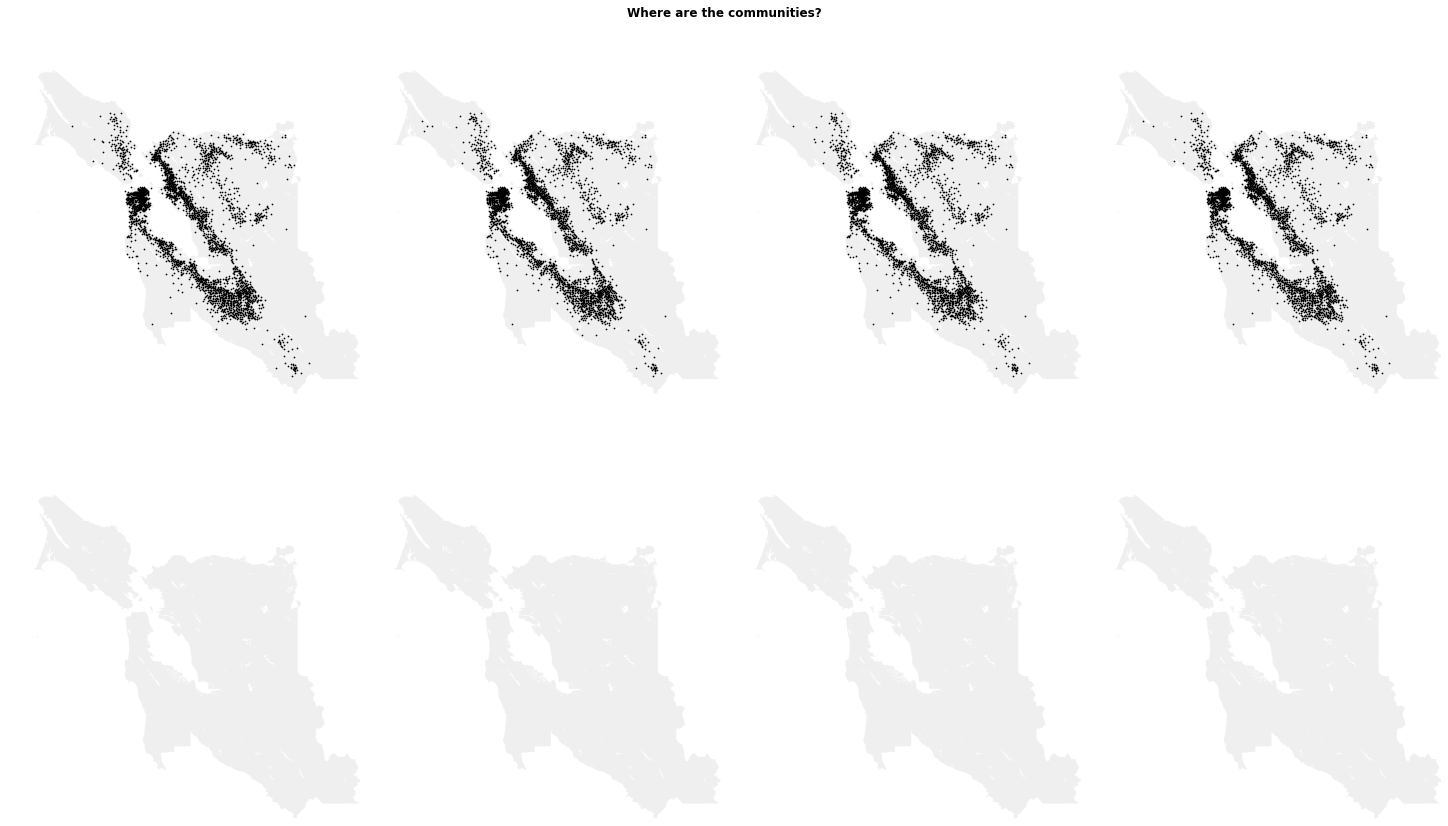

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(20, 12), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 8):
    
    print(i)
    
    temp = joined[joined['variable']==i]
    
    background.plot(color='dimgray', ax=axs[i], alpha=0.1)
    temp.centroid.plot(color='k', markersize=0.5, ax=axs[i])

    axs[i].margins(0)
    axs[i].axis('off')
    
    
fig.suptitle("Where are the communities?", color='k', weight='bold')

fig.savefig('demon_communities.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [20]:
P = algorithms.pycombo(G, weight='weight', modularity_resolution=1.2)

In [22]:
P_long = pd.DataFrame(P.communities).T.melt()
P_long = P_long.dropna()

In [23]:
P_long['crosswalk'] = P_long['value'].astype('uint64')
joined = P_long.merge(shape.reset_index(), left_on='crosswalk', right_on='cbg', how='left')
joined = gpd.GeoDataFrame(joined)

0
1
2
3
4
5
6
7


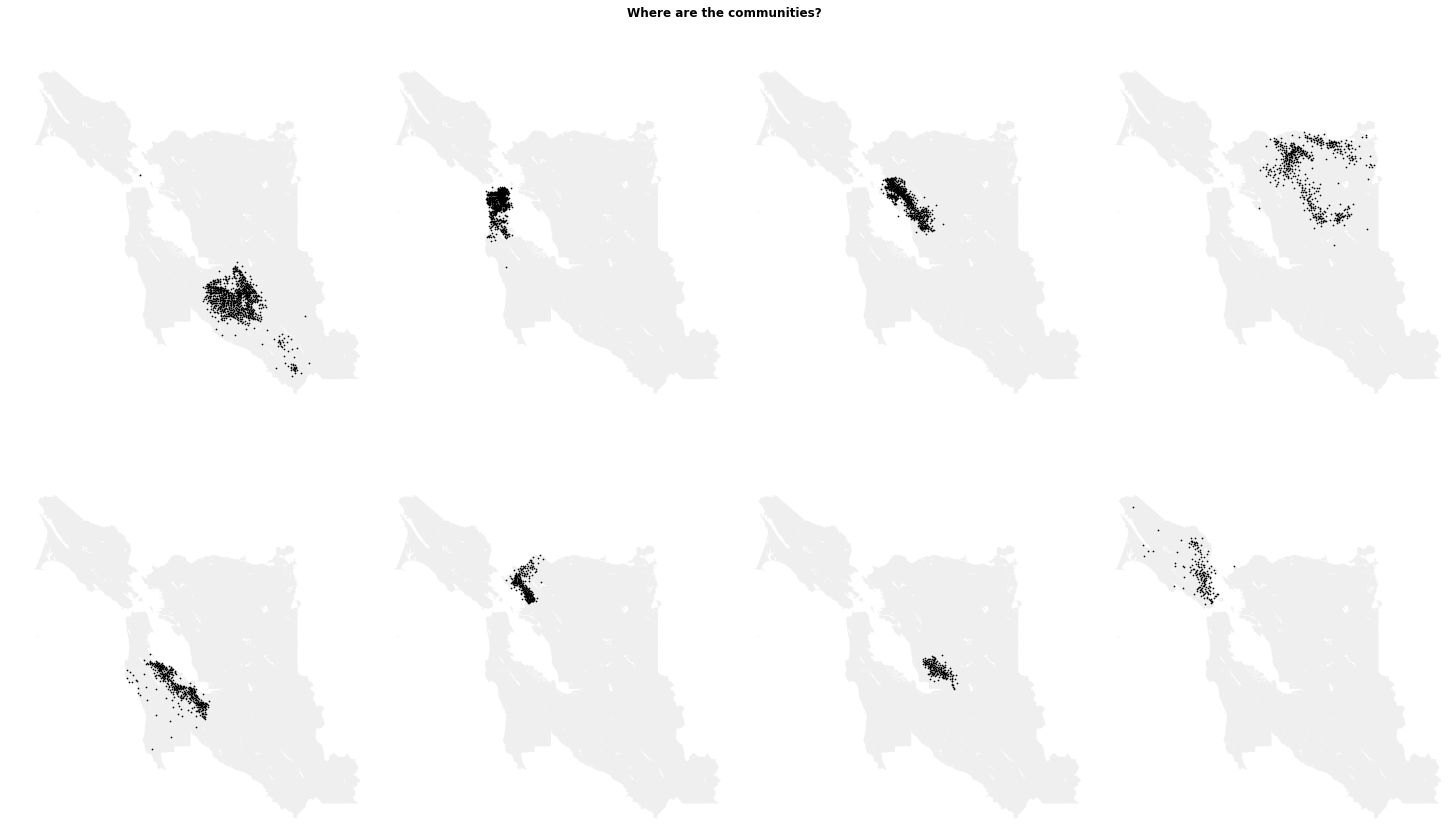

In [28]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(20, 12), 
                       facecolor='w',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 8):
    
    print(i)
    
    temp = joined[joined['variable']==i]
    
    background.plot(color='dimgray', ax=axs[i], alpha=0.1)
    temp.centroid.plot(color='k', markersize=0.5, ax=axs[i])

    axs[i].margins(0)
    axs[i].axis('off')
    
    
fig.suptitle("Where are the communities?", color='k', weight='bold')

fig.savefig('combo_communities.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')